# Fuel consumption and C02 emission data Analysis

## Data Understanding

The data was collected from the [Canada Open Government portal](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64).
The data contains model-specific fuel consumption ratings and Co2 emissions for light-weigh vehicles. 
The respective fields in the dataset are:

- **MODELYEAR** e.g. 2014
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. SUV
- **ENGINE SIZE** e.g. 4.7
- **CYLINDERS** e.g 6
- **TRANSMISSION** e.g. A6
- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
- **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0

See the datasource for the full [**`data dictionary`**](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64/resource/b6100f60-5e63-437d-b122-db76c467c0a7). 

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import PredictionErrorDisplay, r2_score, mean_squared_error,mean_absolute_error 
%matplotlib inline

### Download the data

In [2]:
url = "https://open.canada.ca/data/en/datastore/dump/b6100f60-5e63-437d-b122-db76c467c0a7?bom=True"
df = pd.read_csv(url)
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2023,Acura,Integra,Full-size,1.5,4,AV7,Z,7.9,6.3,7.2,39,167,6,7
1,2023,Acura,Integra A-SPEC,Full-size,1.5,4,AV7,Z,8.1,6.5,7.4,38,172,6,7
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4,M6,Z,8.9,6.5,7.8,36,181,6,6
3,2023,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
4,2023,Acura,MDX SH-AWD Type S,Sport utility vehicle: Standard,3.0,6,AS10,Z,13.8,11.2,12.4,23,291,4,5


### Drop columns that are not needed and rename columns

In [3]:
df.drop(
    columns=["CO2 rating", "Smog rating", "Combined (mpg)"],
    inplace=True,
)

original_columns = [
    "Model year",
    "Make",
    "Model",
    "Vehicle class",
    "Engine size (L)",
    "Cylinders",
    "Transmission",
    "Fuel type",
    "City (L/100 km)",
    "Highway (L/100 km)",
    "Combined (L/100 km)",
    "CO2 emissions (g/km)",
]

new_columns = [
    "Model_Year",
    "Make",
    "Model",
    "Vehicle_Class",
    "Engine_Size",
    "Cylinders",
    "Transmission",
    "Fuel_Type",
    "City_Liters_100km",
    "Highway_Liters_100km",
    "Fuel_Consumption_Liters_100km",
    "Co2_Emissions",
]

df.rename(columns={k: v for k, v in zip(original_columns, new_columns)}, inplace=True)
df.columns

Index(['Model_Year', 'Make', 'Model', 'Vehicle_Class', 'Engine_Size',
       'Cylinders', 'Transmission', 'Fuel_Type', 'City_Liters_100km',
       'Highway_Liters_100km', 'Fuel_Consumption_Liters_100km',
       'Co2_Emissions'],
      dtype='object')

# Data Exploration

Markdown Checking for data types 

In [4]:
df.dtypes

Model_Year                         int64
Make                              object
Model                             object
Vehicle_Class                     object
Engine_Size                      float64
Cylinders                          int64
Transmission                      object
Fuel_Type                         object
City_Liters_100km                float64
Highway_Liters_100km             float64
Fuel_Consumption_Liters_100km    float64
Co2_Emissions                      int64
dtype: object

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Model_Year,840.0,2023.000000,0.000000,2023.0,2023.0,2023.00,2023.0,2023.0
Engine_Size,840.0,3.156429,1.357584,1.2,2.0,3.00,3.6,8.0
Cylinders,840.0,5.638095,1.968156,3.0,4.0,6.00,6.0,16.0
City_Liters_100km,840.0,12.472857,3.521976,4.4,10.1,12.10,14.7,30.7
Highway_Liters_100km,840.0,9.375238,2.322021,4.4,7.7,9.10,10.8,20.9
Fuel_Consumption_Liters_100km,840.0,11.079405,2.922971,4.4,9.0,10.75,12.9,26.1
Co2_Emissions,840.0,258.055952,64.665568,104.0,211.0,255.00,299.0,608.0


In [6]:
df.isnull().sum()

Model_Year                       0
Make                             0
Model                            0
Vehicle_Class                    0
Engine_Size                      0
Cylinders                        0
Transmission                     0
Fuel_Type                        0
City_Liters_100km                0
Highway_Liters_100km             0
Fuel_Consumption_Liters_100km    0
Co2_Emissions                    0
dtype: int64

## Univariate feature exploration

Plotting the model year column

In [7]:
plt.style.use("seaborn-v0_8-talk")

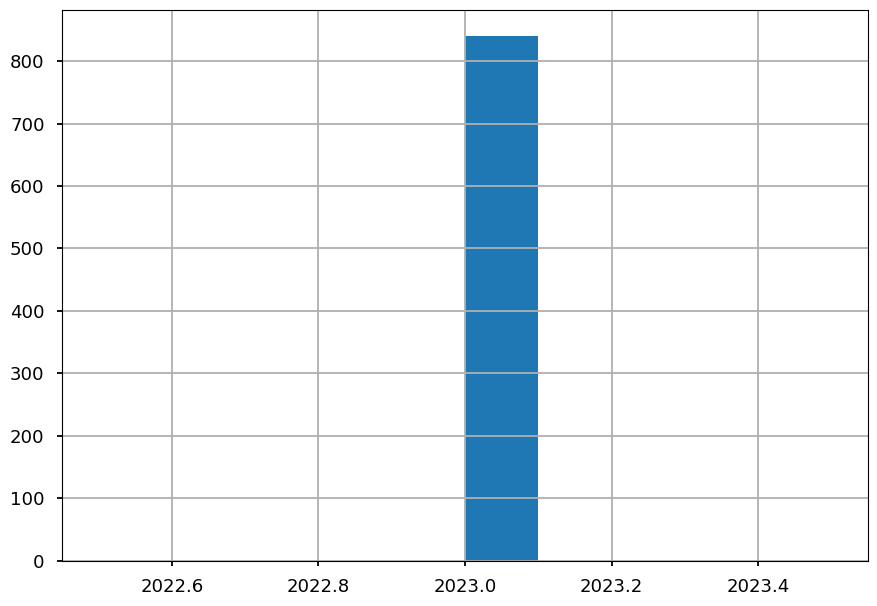

In [8]:
df.Model_Year.hist()
plt.show()

Only one year exist. There is no variance in the model year. Droping the model year 


In [9]:
df.drop(columns=["Model_Year"], inplace= True)

Plotting the Distribution of `engine size`

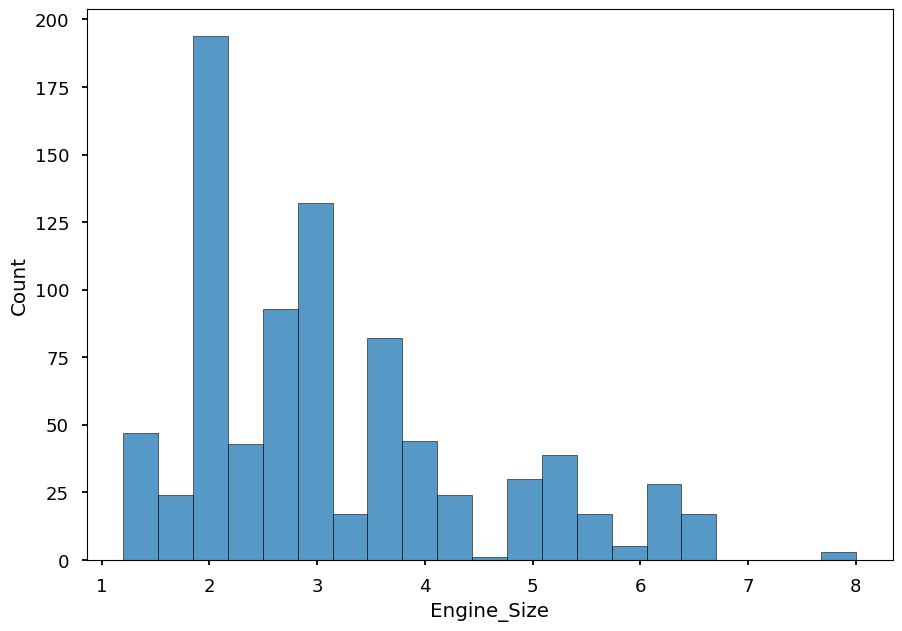

In [10]:
sns.histplot(x=df.Engine_Size)
plt.show()

In [11]:
df.groupby(df.Engine_Size)["Engine_Size"].count().sort_values(ascending=False).to_frame().head(10)

,Engine_Size
Engine_Size,
2.0,194
3.0,126
2.5,63
3.5,46
3.6,36
1.5,36
4.0,34
5.0,30
2.7,30


Most cars have engine sizes between 2.0 and 4.0, with Engine sizes 2.0 and 3.0 being the leading engine size

<Axes: ylabel='Engine_Size'>

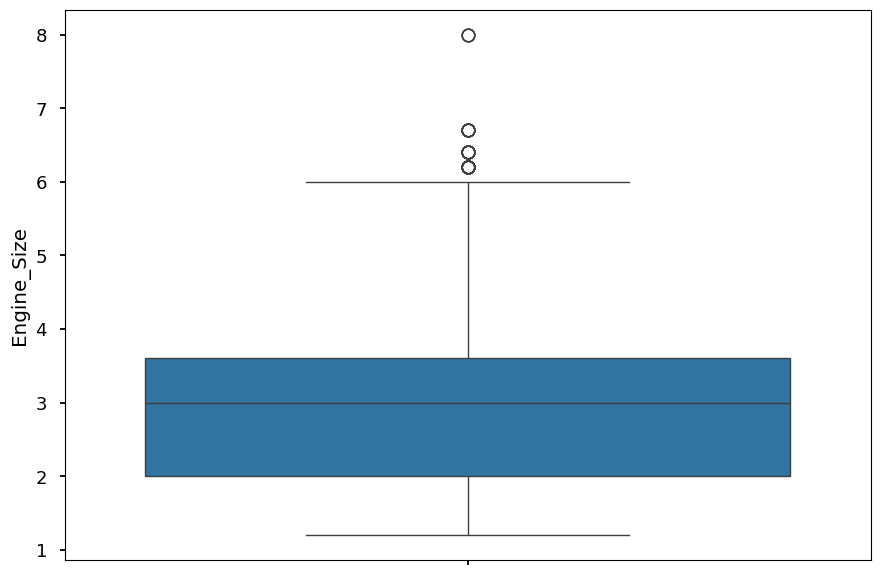

In [12]:
sns.boxplot(df.Engine_Size)

Median engine size is 3.0. There are some cars engines sizes that are outliers (1.5 times more than the inter quartile ranges), with engines sizes higers than 6.0. 
It will be interesting to compare their C02 emission with the other engine types. 
Hypothetically, these outlier engine size cars should have higher C02 emission. This can be tested with a correlation 

Plotting the Distribution of `C02 Emission`

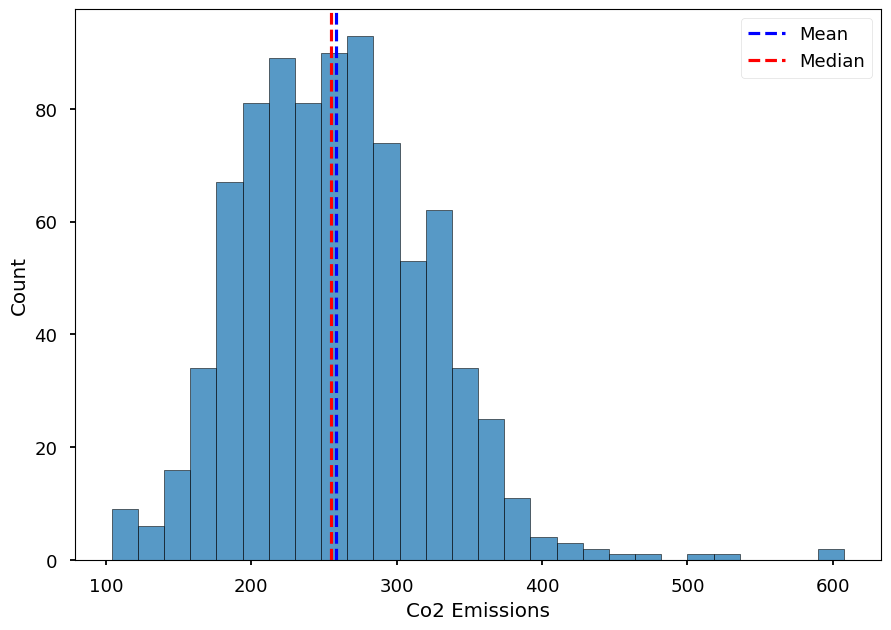

In [21]:
sns.histplot(x=df.Co2_Emissions)
plt.axvline(df.Co2_Emissions.mean(), color="b", linestyle="dashed", label="Mean")
plt.axvline(df.Co2_Emissions.median(), color="r", linestyle="dashed", label="Median")
plt.xlabel("Co2 Emissions")
plt.legend()
plt.show()

The Distribution of C02 emissions is more closer to a normal distribution, given that the mean and median are almost equal. Are there any outliers ?

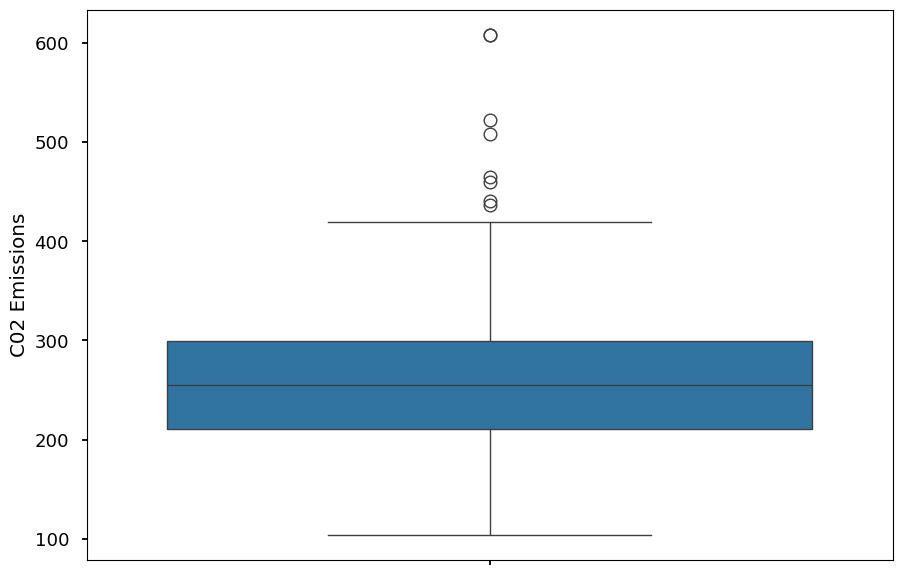

In [22]:
sns.boxplot(df.Co2_Emissions)
plt.ylabel("C02 Emissions")
plt.show()

There are some outliers with more than 400 g/km Co2 Emissions

Univariate exploratory analysis can be done for other feature. Skipping to Multivariate exploration

## Multivariate Exploration

Is there a correlation between Engine Size and Co2 Emissions ?

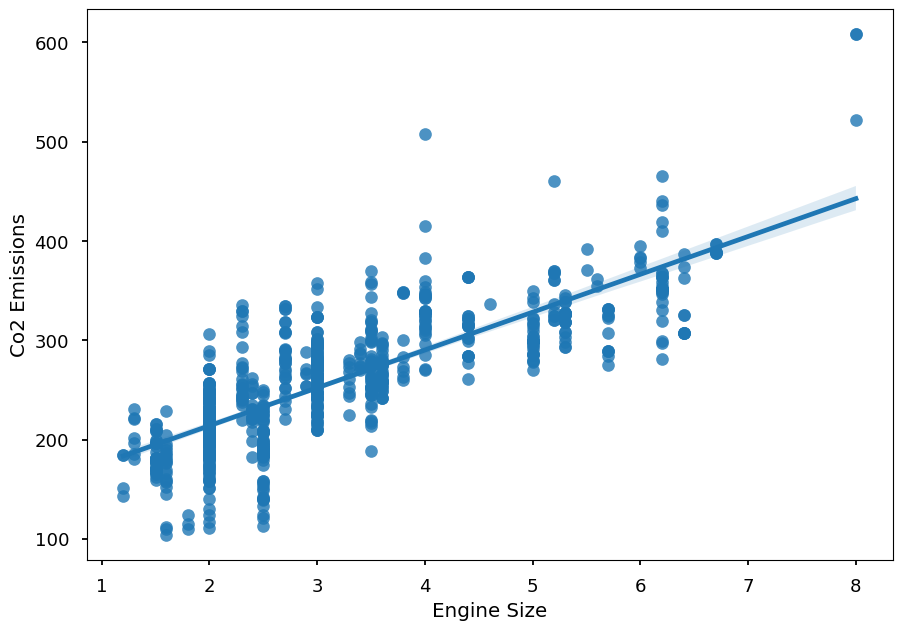

In [27]:
sns.regplot(x=df.Engine_Size, y= df.Co2_Emissions)
plt.xlabel("Engine Size")
plt.ylabel("Co2 Emissions")
plt.show()

There is a postive correlation between Engine Size and C02 Emissions. How strong is the correlation ? 

What is the correlation betweeen Cylinders and Co2 Emissions ? 

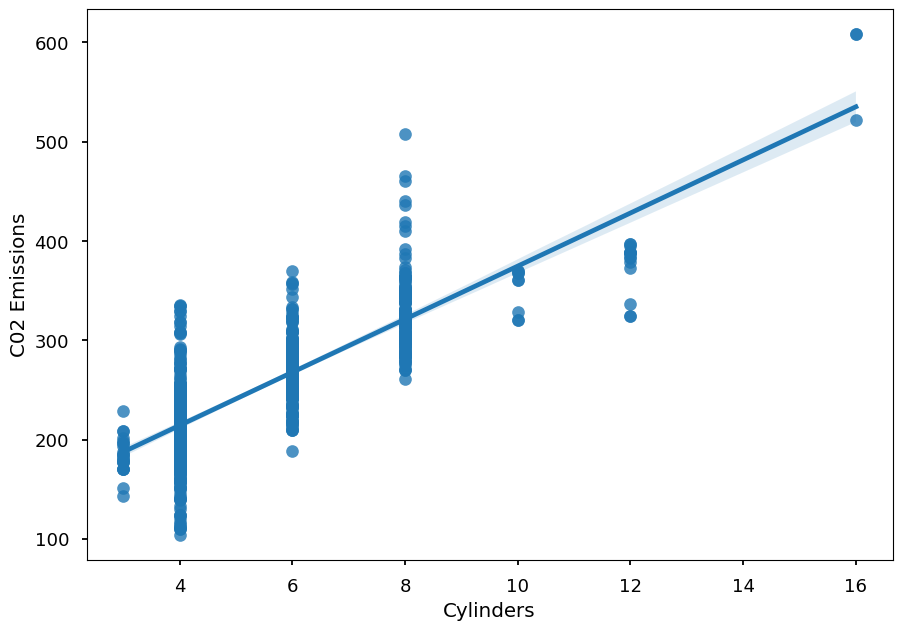

In [28]:
sns.regplot(x=df.Cylinders, y = df.Co2_Emissions)
plt.ylabel("C02 Emissions")
plt.show()

There is a positive correlation. How strong is the correlation ? 

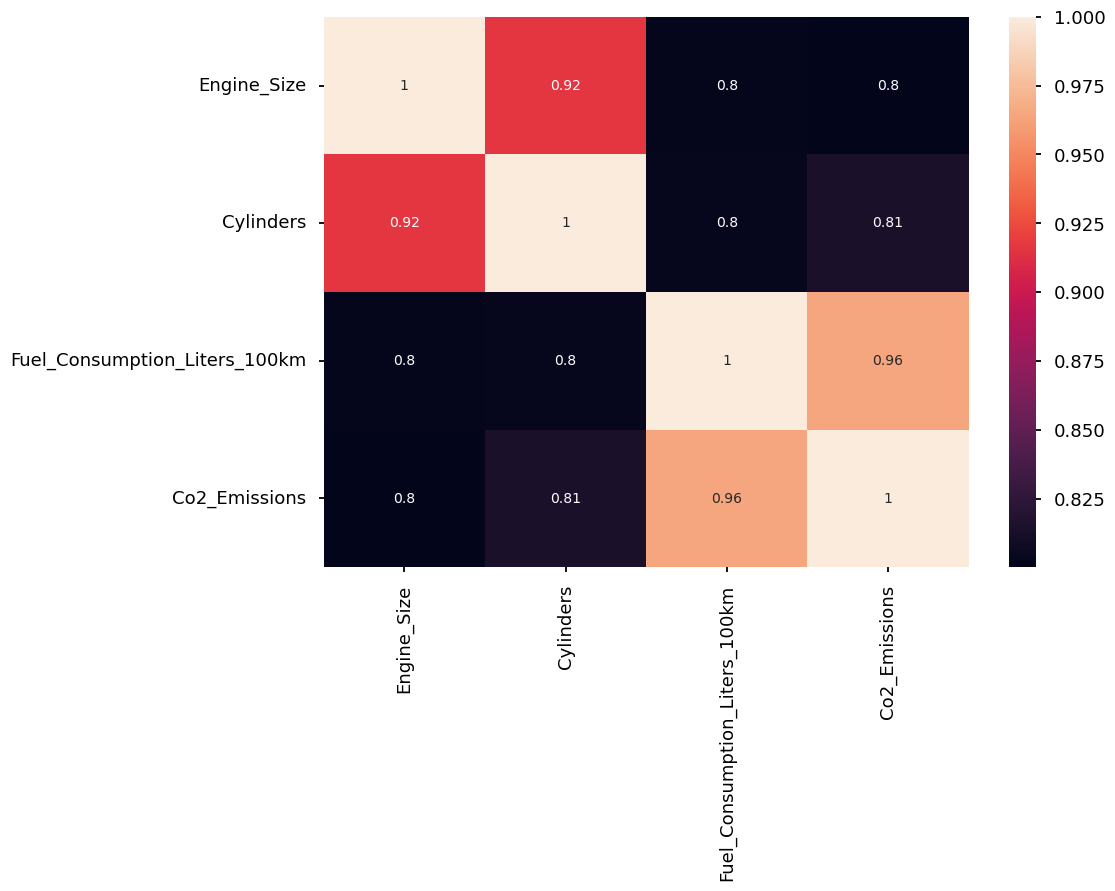

In [19]:
corr=df[["Engine_Size","Cylinders", "Fuel_Consumption_Liters_100km","Co2_Emissions"]].corr()
sns.heatmap(data=corr, annot=True)
plt.show()

* There is strong correlation between Co2 Emissions and 
    - Engine_Size
    - Fuel consumption and 
    - Cylinders
* There is also notable Multicollinearity between Engine Size, Fuel compution and Cylinders. In other words, all the independent variables are correlations

# Predicting Co2 Emission with simple Linear models

In [40]:
df_features=df[["Engine_Size","Cylinders", "Fuel_Consumption_Liters_100km"]]
df_target=df["Co2_Emissions"]

x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=1) 


Training a Linear Regression model with Engine_Size as feature/independent variable

In [47]:
slr = LinearRegression()
slr.fit(x_train[["Engine_Size"]],y_train)

print ('Coefficients: ', slr.coef_[0])
print ('Intercept: ',slr.intercept_)

Coefficients:  38.69147169081348
Intercept:  136.9833587156329


The simple linear model fit line is Co2_Emissions = 136.9833587156329 + 38.69147169081348 * Engine_Size

In [62]:
y_train_pred = slr.predict(x_train[["Engine_Size"]])

Plotting the training set distribution and regression fit line, first with matplotlib. This can also be done with seaborn regplot. 

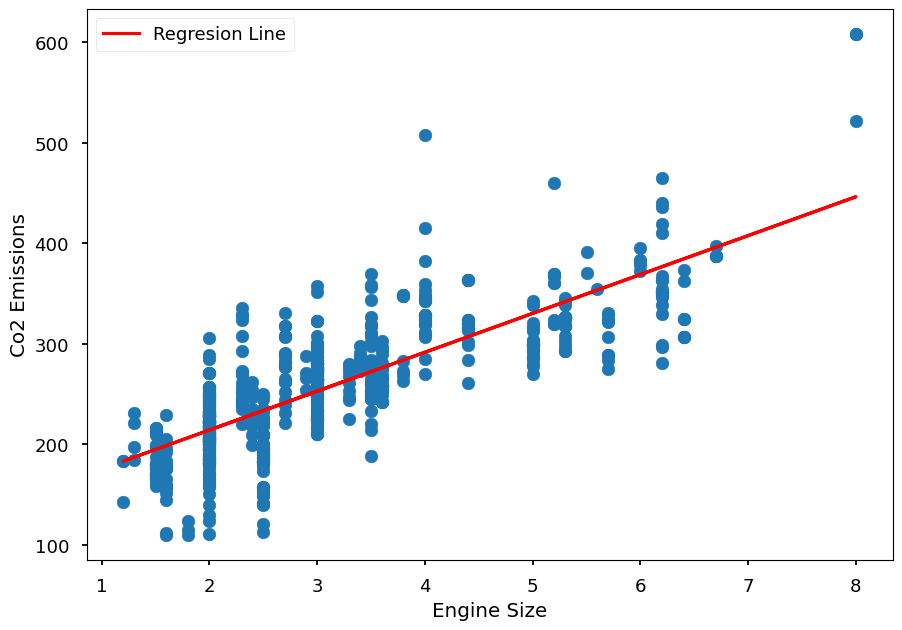

In [64]:
plt.scatter(x=x_train[["Engine_Size"]], y=y_train)
plt.plot(x_train[["Engine_Size"]], y_train_pred, "-r", label="Regresion Line")
plt.xlabel("Engine Size")
plt.ylabel("Co2 Emissions")
plt.legend()
plt.show()

Plotting the residuals to know the relations between prediction error and co2 Emission on the training dataset

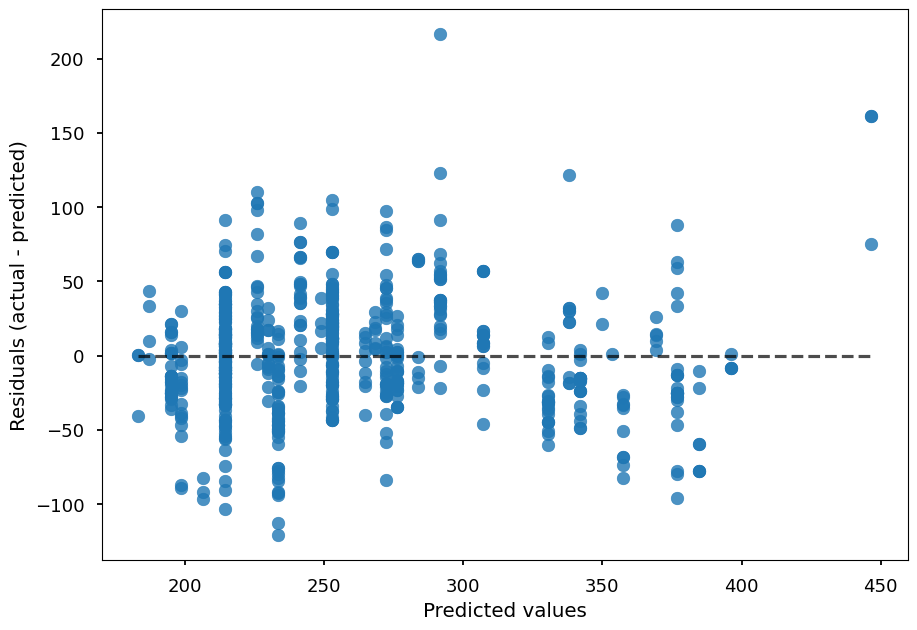

In [67]:
resid = PredictionErrorDisplay(y_true=y_train, y_pred= y_train_pred)
resid.plot()
plt.show()

The residual plots does not show consistent distribution around the mean (inconsistence variance). There some sub points of Co2 emissions predicted with higher errors than others. More training data or a polynomial regression would the necessary

Evaluating the simple linear regression on the test set

In [75]:
y_test_pred = slr.predict(x_test[["Engine_Size"]])

In [78]:
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_test_pred))
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test,y_test_pred))
print("R2-score: %.2f" % r2_score(y_test,y_test_pred) )

Mean absolute error: 28.41
Mean squared error (MSE): 1388.88
R2-score: 0.63


Simple Linear regression using Cylinlders as feature can be added. Skipping to multiple linear regression

# Predicting Co2 Emission with Multiple Linear models

A Linear Regression model will be trained with `Engine_Size`, `Cylinders`,  and `Fuel_Consumption_Liters_100km`

In [87]:
mlr = LinearRegression()
mlr.fit(x_train,y_train)

LinearRegression()

Make Co2 Emission predictions with the training set

In [102]:
y_mlr_train_pred = mlr.predict(x_train)

Plotting the distribution of the true and predicted Co2 Emissions

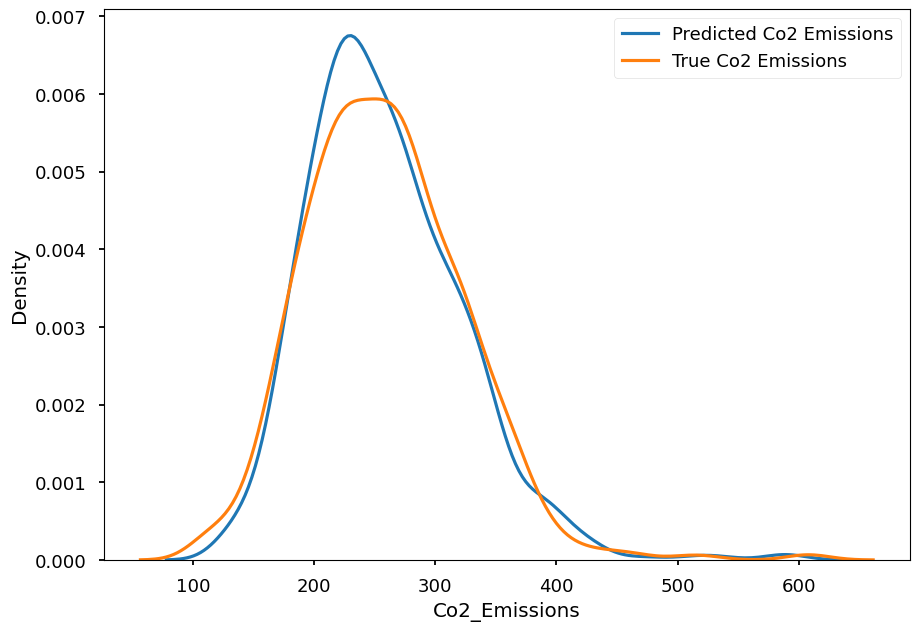

In [105]:
ax=sns.kdeplot(y_mlr_train_pred, label ="Predicted Co2 Emissions (train)")
sns.kdeplot(y_train,ax=ax, label="True Co2 Emissions (train)")
plt.legend()
plt.show()

The model makes higher errors in predicting Co2 Emisisons in ranges 200-300. More dataset in these might improve the performance. Examining the residual plot

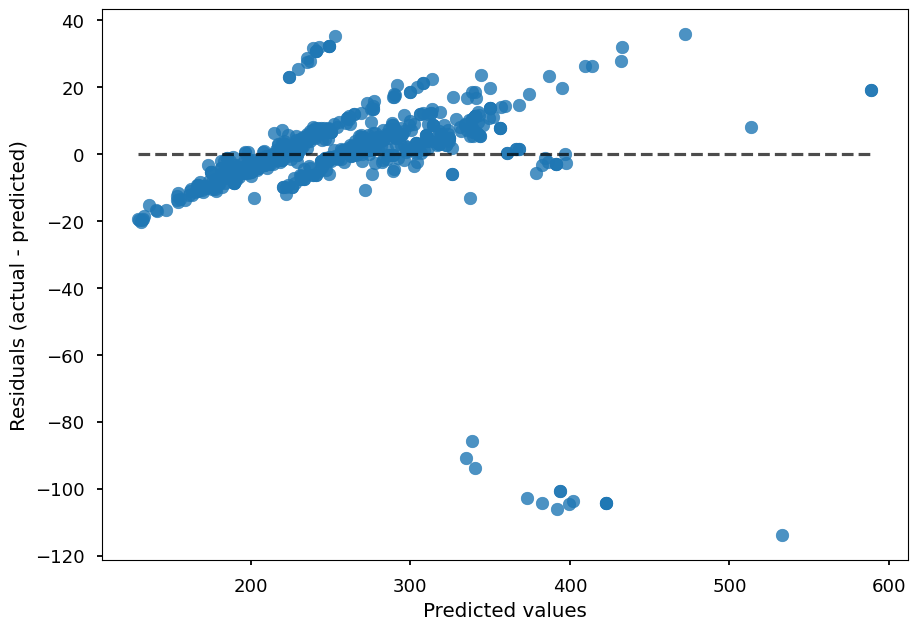

In [110]:
resid = PredictionErrorDisplay(y_true=y_train, y_pred = y_mlr_train_pred)
resid.plot()
plt.show()

The residual plots shows a very that Multiple Linear Regression is not best estimator given the feature set. There is a pattern in the residual plots 

Evaluating the multiple linear regression model on the test 

In [111]:
y_mlr_test_pred = mlr.predict(x_test)

In [112]:
print("Mean absolute error: %.2f" % mean_absolute_error(y_test,y_mlr_test_pred))
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test,y_mlr_test_pred))
print("R2-score: %.2f" % r2_score(y_test,y_mlr_test_pred) )

Mean absolute error: 7.40
Mean squared error (MSE): 209.21
R2-score: 0.94


The erors and R2 score has improved significantly compared to the single linear regression. But can this result generalize on new data ? Investigation of over fitting is needed. Remember the correlation matrix shows multicolinearity and the residual plots suggest overfitting. 

Plotting the distributions of the test set and the prediction on the tes set

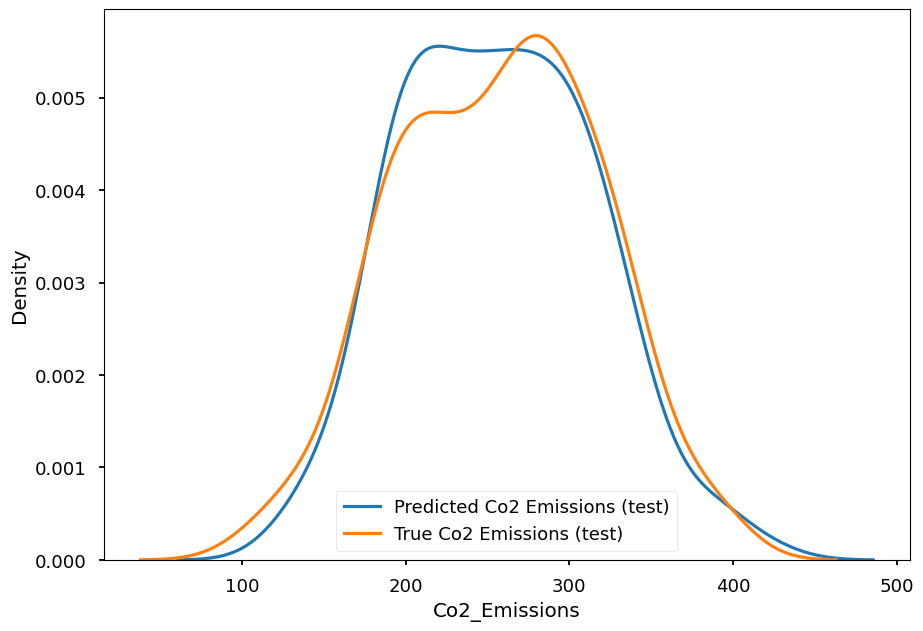

In [117]:
ax=sns.kdeplot(y_mlr_test_pred, label ="Predicted Co2 Emissions (test)")
sns.kdeplot(y_test,ax=ax, label="True Co2 Emissions (test)")
plt.legend()
plt.show()